# Clustering Yelp Restaurants

**Part 1: To be completed INDIVIDUALLY and due on October 14 at 7pm.**

In this assignment, we will be working with the [Yelp dataset](https://drive.google.com/open?id=0B4bdB5WPHGsqcmJMNmxzQmQ3aTQ). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

From the Business Objects, let's try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You may want to use only a subset (15-20) of popular categories.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Clusters labeled by top category for Kmeans, Hierarichal, GMM in the format: [c0, c1, c2,..., c13, c14, c15] where c = cluster

Kmeans:
['categories=Italian', 'categories=Sandwiches', 'categories=Mexican', 'categories=Burgers', 'categories=American (New)', 'categories=Fast Food', 'categories=American (Traditional)', 'categories=Seafood', 'categories=American (New)', 'categories=Japanese', 'categories=Chinese', 'categories=Nightlife', 'categories=Fast Food', 'categories=Pizza', 'categories=Sandwiches']

Hierarchical:
['categories=Bars', 'categories=Chinese', 'categories=American (New)', 'categories=American (Traditional)', 'categories=American (New)', 'categories=Japanese', 'categories=American (Traditional)', 'categories=Breakfast & Brunch', 'categories=Breakfast & Brunch', 'categories=American (New)', 'categories=Nightlife', 'categories=Nightlife', 'categories=Sushi Bars', 'categories=American (New)', 'categories=Japanese']

GMM:
['categories=Pizza', 'categories=Japanese', 'categories

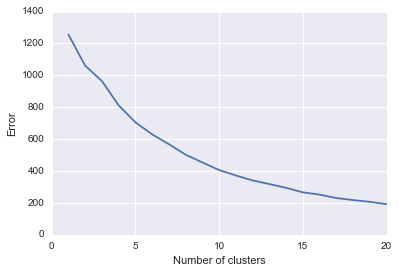

In [1]:
import json
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from pylab import plot,show
from sklearn import mixture
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as metrics
from numpy import array

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.manifold

# getting number of clusters retrieving the top clusters 
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
    
# loading dataset
data = []
with open('yelp_academic_dataset_business.json') as f:
    for line in f:
        data.append(json.loads(line))

# fetching all the restaurants in Las Vegas from data
restaurants = [dic for dic in data if 'Restaurants' in dic['categories'] and dic['city'] == 'Las Vegas']

# blacklist are the keys that aren't kept in the dataset
blacklist = list(restaurants[0].keys())
keep = ['categories','longitude','latitude']
blacklist = [key for key in blacklist if key not in keep]

# filteredRes is list of restaurants after: removing irrelevant fields, restaurants and food from categories because they are not unique categories
# categories stores all of categories' values
categories = []
filtered_Res = []

for res in restaurants:
    res['categories'].remove('Restaurants')
    if ('Food' in res['categories']):
        res['categories'].remove('Food')
        
    if (len(res['categories']) != 0):
        categories.extend(res['categories'])
        for key in blacklist:
            del res[key]
        filtered_Res.append(res)
        
# top_cat counts frequency of categories and lists them in decreasing order of occurances
# top_cat_18 lists top 18 popular restaurant categories
top_cat = Counter(categories).most_common()
top_cat_15 = top_cat[0:15]
top_cat_15 = [cat[0] for cat in top_cat_15]

# filtering dataset on restaurants that have top categories, transforming dictionary so that it can be vectorized
# only top categories of retaurants are kept for later use
transformed_Res = []
for res in filtered_Res:
    copy = False
    for cat in res['categories']:
        if cat in top_cat_15:
            copy = True
            res['categories={}'.format(cat)] = True
    if copy:
        del res['categories']
        transformed_Res.append(res)
        
# vectorized categories with latitude and longitude
vectorizer = DictVectorizer()
res_data = vectorizer.fit_transform(transformed_Res).toarray()

# scaling vectorized restaurant data
res_data_scaled = []
rdsnp = np.array(res_data_scaled)
scale = 0.5
for vec in res_data:
    cat_scaled = [0]*len(vec)
    for i in range(15):
        cat_scaled[i] = scale*vec[i]
    cat_scaled[15] = vec[15]
    cat_scaled[16] = vec[16]
    res_data_scaled.append(cat_scaled)

# getting k-means
k=15
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit_predict(res_data_scaled)
k_labels = kmeans.labels_

# Hierarchical 
ward = AgglomerativeClustering(n_clusters=k, linkage='complete')
ward.fit_predict(res_data_scaled)
h_labels = ward.labels_

# GMM: Fit a mixture of Gaussians with EM using two components
gmm = mixture.GMM(n_components=k, covariance_type='full')
gmm.fit(res_data_scaled)
gmm_labels = gmm.predict(res_data_scaled)


# getting top terms per cluster for kmeans
asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()

# getting top term of clusters for kmeans, hierarichal, and gmm
print("Clusters labeled by top category for Kmeans, Hierarichal, GMM in the format: [c0, c1, c2,..., c13, c14, c15] where c = cluster" + "\n")

print("Kmeans:")
k_top_cat_cluster = []
for i in range(k):
    for ind in order_centroids[i, :2]:
        if (terms[ind] != 'latitude'):
            k_top_cat_cluster.append(terms[ind])
print(k_top_cat_cluster)
print()

# taken from stackoverflow: http://stackoverflow.com/questions/29799053/how-to-print-result-of-clustering-in-sklearn
print("Hierarchical:")
clusters = {}
h_top_cat_cluster = []
n = 0
for item in h_labels:
    if item in clusters:
        clusters[item].append(res_data_scaled[n])
    else:
        clusters[item] = [res_data_scaled[n]]
        h_top_cat_cluster.append(terms[h_labels[item]])
    n +=1
print(h_top_cat_cluster)
print()

print("GMM:")
clusters = {}
gmm_top_cat_cluster = []
n = 0
for item in gmm_labels:
    if item in clusters:
        clusters[item].append(res_data_scaled[n])
    else:
        clusters[item] = [res_data_scaled[n]]
        gmm_top_cat_cluster.append(terms[gmm_labels[item]])
    n +=1
print(gmm_top_cat_cluster)
print()

print('evaluating optimum number of clusters (number of clusters vs error)')
evaluate_clusters(res_data_scaled,20)

Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(10 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

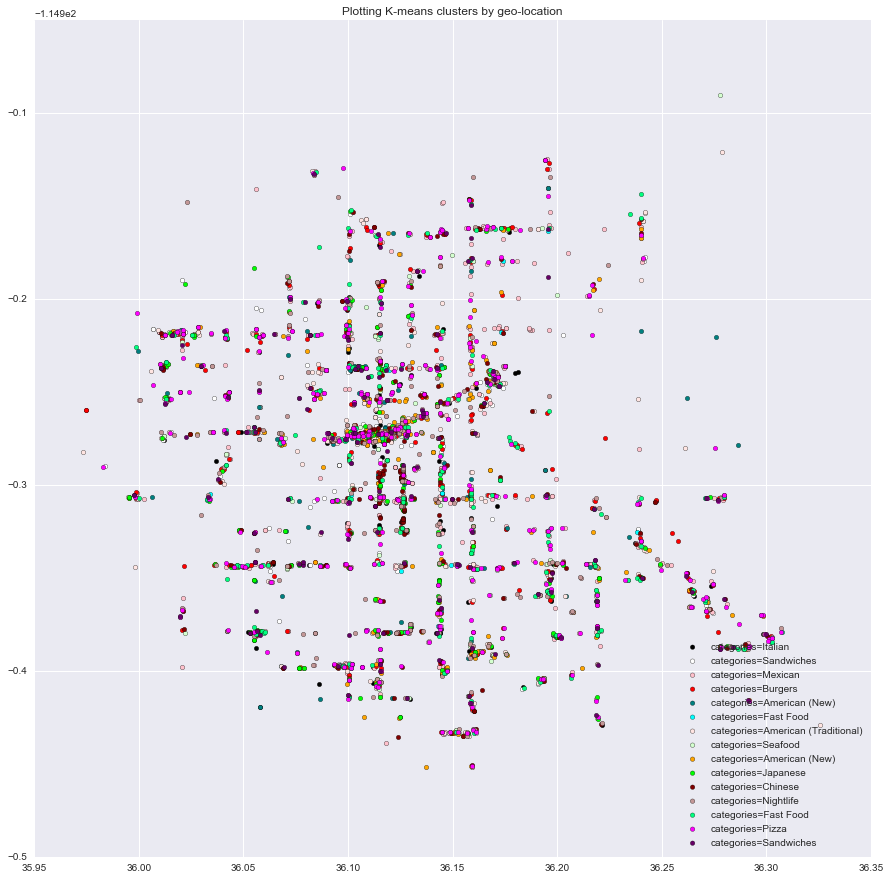

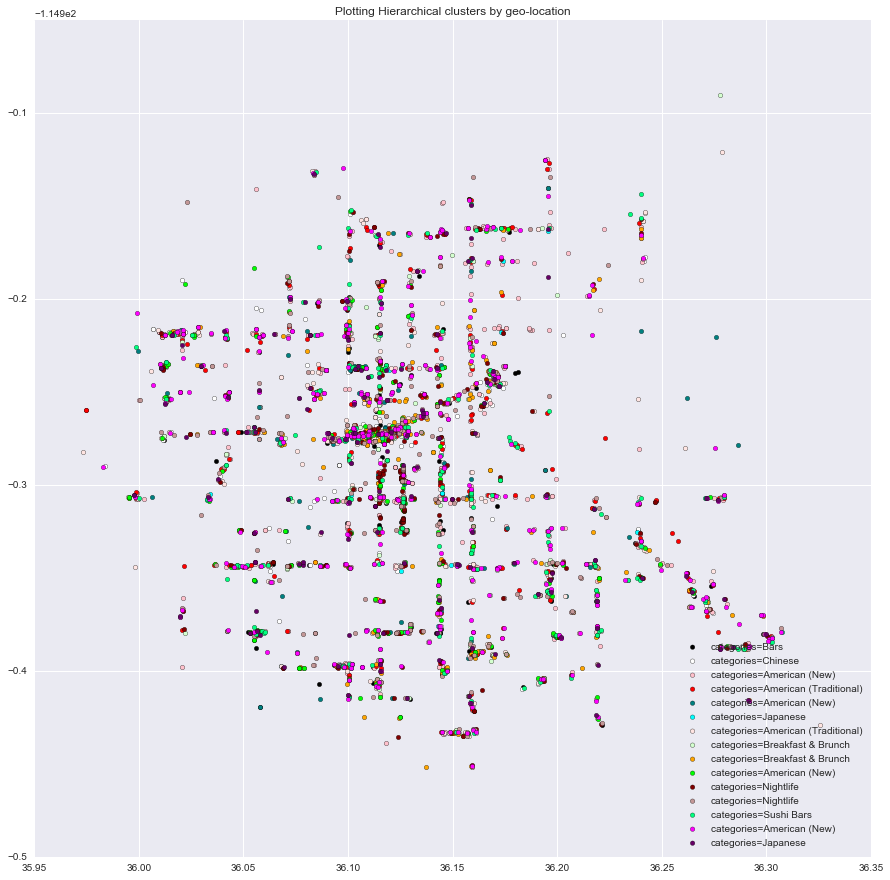

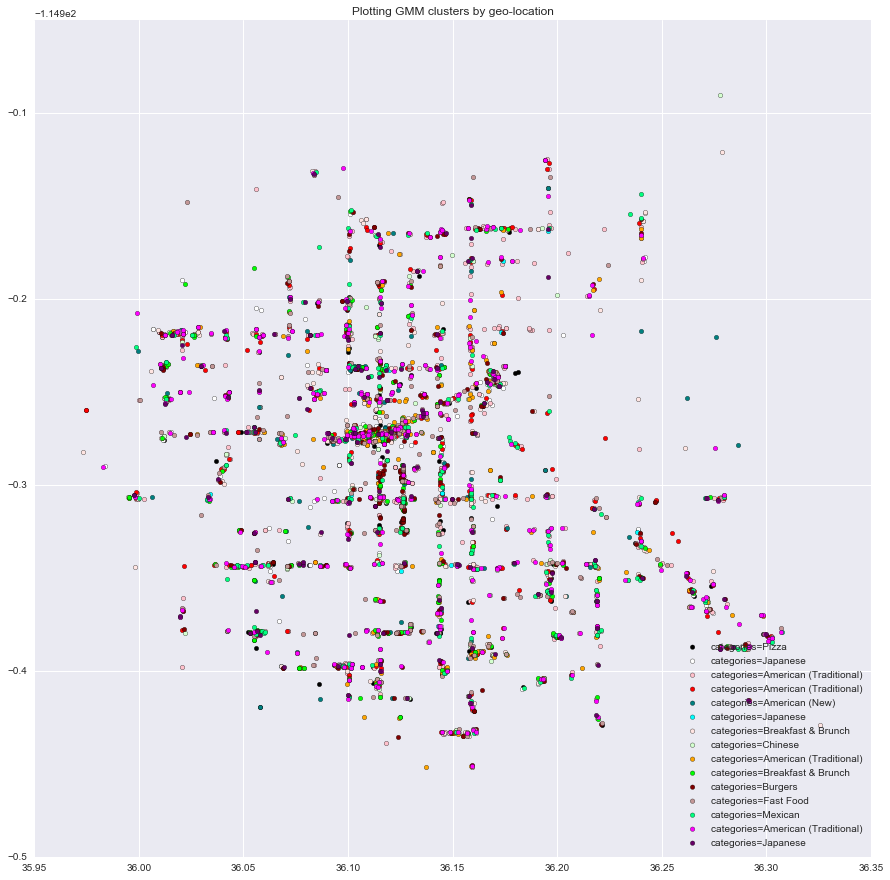

In [2]:
centroids = kmeans.cluster_centers_
cols = ["#000000", "#ffffff", "#ffc0cb", "#ff0000", "#008080", "#00ffff", "#ffe4e1", "#d3ffce", "#ffa500", "#00ff00", "#800000", "#c39797", "#00ff7f", "#ff00ff", "#660066"]

# plotting the points by cluster for K-means
plt.figure(figsize=(15,15))
master_cluster_list = {i: np.where(k_labels == i)[0] for i in range(15)}
for cluster in master_cluster_list:
    cluster_vec = []
    for i in master_cluster_list[cluster]:
        temp = list(res_data_scaled[i])
        cluster_vec.append(temp)
    cluster_vec_np = array(cluster_vec)
    plt.scatter(cluster_vec_np[:, 15], cluster_vec_np[:, 16], c=cols[cluster], label=k_top_cat_cluster[cluster])
plt 
plt.title("Plotting K-means clusters by geo-location")
plt.legend(loc=4)

#plotting the points by cluster for Hierarchical 
plt.figure(figsize=(15,15))
master_cluster_list_h = {i: np.where(h_labels == i)[0] for i in range(15)}
for cluster in master_cluster_list_h:
    cluster_vec = []
    for i in master_cluster_list[cluster]:
        temp = list(res_data_scaled[i])
        cluster_vec.append(temp)
    cluster_vec_np = array(cluster_vec)
    plt.scatter(cluster_vec_np[:, 15], cluster_vec_np[:, 16], c=cols[cluster], label=h_top_cat_cluster[cluster])

plt.title("Plotting Hierarchical clusters by geo-location")
plt.legend(loc=4)

# plotting the points by cluster for GMM
plt.figure(figsize=(15,15))
master_cluster_list_g = {i: np.where(gmm_labels == i)[0] for i in range(15)}
for cluster in master_cluster_list_g:
    cluster_vec = []
    for i in master_cluster_list[cluster]:
        temp = list(res_data_scaled[i])
        cluster_vec.append(temp)
    cluster_vec_np = array(cluster_vec)
    plt.scatter(cluster_vec_np[:, 15], cluster_vec_np[:, 16], c=cols[cluster], label=gmm_top_cat_cluster[cluster])
plt.title("Plotting GMM clusters by geo-location")
plt.legend(loc=4)

The category label for each cluster is defined by the most popular category that is for each cluster.  This is determined by getting all the categories of each group and assigns the most frequent category that appears for the cluster as its label.

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

The centroids point to the center of the graph for K-means.  Notice that the outliers web out.  One such example is the Japanese cluster which dominates the Southern portion of the graph.  However there are a few green data points (per Japanese) far from their cluster in the Northern quandrants.  This indicates that while certain types of restaurants may have a specific area that they prefer, there is a good distribution of the same types of restaurants in other areas.

Give a detailed analysis comparing the results you obtained from the 3 techniques. **(10 pts)**

It can be noted that there are unique categories for each K-means cluster as supposed to Hierarchical and GMM clusters, which  are of more similarity with each other.  For GMM this makes a lot of sense. Whereas Kmeans uses hard assignments, such that each point belongs to one cluster or another but never belonging to more than one, Gaussian makes soft assignments: data points do not belong to a single cluster but has some probability of belonging to each individual cluster. So some points may have a high probability of belonging to the same category due to their vicinity with each other and similarity of popular categories.  Because we are using the same number of clusters, determined by evaluating the error function for K-means as a method to compare their clustering techniques and how they assign points to groups, GMM determines that some points belong to one or more clusters and therefore assigns the same top category to serveral clusters.  Hierarchical performs nested clustering so may have determined American (New) to be a parent cluster, since most restaurants have American (New) as a popular category.